In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import numpy as np
import pdb

# my code
from distribution import RBMLatentPosterior, MultivariateBernoulliNoise
from latent_nce_optimiser import LatentNCEOptimiser, CDOptimiser
from latent_variable_model import RestrictedBoltzmannMachine

from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

# For reproducibility
rng = rnd.RandomState(1083463236)

# Model and optimiser definition

In [3]:
n = 100000 # number of datapoints
nz = 1  # number latent samples per datapoint
nu = 1
d = 10  # visible dimension
m = 4  # latent dimension
true_W = rnd.uniform(-0.5, 0.5, (d+1, m+1))  # true setting of the weights, that we are trying to learn
#theta0 = rnd.randn(d+1, m+1)*0.01  # random initialisation of weights
theta0 = true_W

In [4]:
cd_num_steps = 1
cd_learn_rate = 0.001
cd_batch_size = 10

In [5]:
true_data_dist = RestrictedBoltzmannMachine(true_W)
X, Z = true_data_dist.sample(n, num_iter=1000)
X_mean = np.mean(X, axis=0)

In [6]:
model = RestrictedBoltzmannMachine(theta0)

In [7]:
noise = MultivariateBernoulliNoise(X_mean)  # treats visibles as independent, matching the data marginals
var_dist = RBMLatentPosterior(theta0)  # true posterior, which has an analytic expression

In [8]:
optimiser = LatentNCEOptimiser(model, noise, var_dist, n, nu=nu, latent_samples_per_datapoint=nz)
cd_optimiser = CDOptimiser(model)

# Validation of synthetic dataset

In [9]:
all_visibles = true_data_dist.get_all_binary_vectors(d)
visible_probs, norm_const = true_data_dist.normalised_and_marginalised_over_z(all_visibles)

In [10]:
print('Sum over all visible probabilities should equal 1. We got: {}'.format(sum(visible_probs)))

Sum over all visible probabilities should equal 1. We got: 0.9999999999999997


In [11]:
"""print('-------------------------Visible probability checks--------------------------------------')
for i in range(2**d):
    freq = np.sum(np.product((X == all_visibles[i]), axis=-1))/ len(X)
    print('{}:  Empirical frequency is {}. True probability is {}'.format(all_visibles[i], 
                                                                         freq, visible_probs[i]))"""

"print('-------------------------Visible probability checks--------------------------------------')\nfor i in range(2**d):\n    freq = np.sum(np.product((X == all_visibles[i]), axis=-1))/ len(X)\n    print('{}:  Empirical frequency is {}. True probability is {}'.format(all_visibles[i], \n                                                                         freq, visible_probs[i]))"

In [12]:
print('normalisation constant is: {}'.format(norm_const))

normalisation constant is: 12859.892632157582


In [13]:
all_hiddens = true_data_dist.get_all_binary_vectors(m)
hidden_probs, norm_const = true_data_dist.normalised_and_marginalised_over_u(all_hiddens)

In [14]:
print('Sum over all hidden probabilities should equal 1. We got: {}'.format(sum(hidden_probs)))

Sum over all hidden probabilities should equal 1. We got: 0.9999999999999997


In [15]:
var_dist.alpha = true_W.reshape(-1)
Z_from_posterior_class = var_dist.sample(1000, X)

In [16]:
"""print('-------------------------Hidden probability checks--------------------------------------')
for i in range(2**m):
    freq = np.mean(np.product((Z_from_posterior_class == all_hiddens[i]), axis=(-1)))
    print('{}:  Empirical frequency is {}. True probability is {}'.format(all_hiddens[i], 
                                                                         freq, hidden_probs[i]))"""

"print('-------------------------Hidden probability checks--------------------------------------')\nfor i in range(2**m):\n    freq = np.mean(np.product((Z_from_posterior_class == all_hiddens[i]), axis=(-1)))\n    print('{}:  Empirical frequency is {}. True probability is {}'.format(all_hiddens[i], \n                                                                         freq, hidden_probs[i]))"

# Optimisation

Optimization terminated successfully.
         Current function value: 1.385202
         Iterations: 33
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: 1.385415
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
CPU times: user 1min 48s, sys: 13.2 s, total: 2min 1s
Wall time: 30.5 s


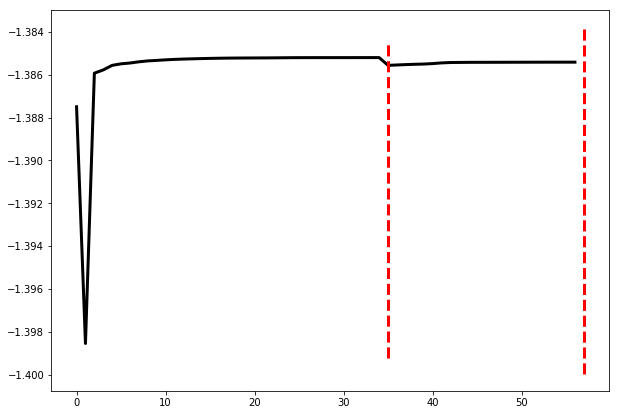

In [17]:
%%time
theta0[0,0] = -np.log(norm_const)
thetas_after_EM_step, J1s, J1_grads = optimiser.fit_using_analytic_q(X, theta0=theta0.reshape(-1), stop_threshold=1e-03)
latent_nce_estimate = model.theta

In [18]:
%%time
thetas_after_each_minibatch = cd_optimiser.fit(X, theta0=theta0.reshape(-1), num_gibbs_steps=cd_num_steps,
                                               learning_rate=cd_learn_rate, batch_size=cd_batch_size)
cd_estimate =  model.theta

CPU times: user 1.33 s, sys: 10.9 ms, total: 1.34 s
Wall time: 1.33 s


# Ground truth vs LatentNCE vs CD

### True parameters

In [19]:
random_true_param_diff = (true_W - theta0).reshape(-1)[1:]
sq_diff_rand_true = np.dot(random_true_param_diff, random_true_param_diff)**0.5
print('Frobenius norm of true weights minus initial weights: {}'.format(sq_diff_rand_true))

Frobenius norm of true weights minus initial weights: 0.0


 ### Parameters learnt with latent NCE

In [20]:
print('Scaling param equals {}'.format(latent_nce_estimate[0]))
print('It should equal {}'.format(-np.log(norm_const)))

Scaling param equals -9.37325771556778
It should equal -9.461868648779898


In [21]:
nce_true_param_diff = (true_W - latent_nce_estimate.reshape(d+1, m+1)).reshape(-1)[1:]
sq_diff_nce_true = np.dot(nce_true_param_diff, nce_true_param_diff)**0.5
print('Frobenius norm of true weights minus latent nce weights: {}'.format(sq_diff_nce_true))

Frobenius norm of true weights minus latent nce weights: 0.22262589800308707


### Parameters learnt with CD

In [22]:
cd_true_param_diff = (true_W - cd_estimate.reshape(d+1, m+1)).reshape(-1)
sq_diff_cd_true = np.dot(cd_true_param_diff, cd_true_param_diff)**0.5
print('Frobenius norm of true weights minus CD weights: {}'.format(sq_diff_cd_true))

Frobenius norm of true weights minus CD weights: 0.028000067972951414


## Visible marginal of model

In [23]:
all_visibles = model.get_all_binary_vectors(d)
model_visible_probs, model_norm_const = model.normalised_and_marginalised_over_z(all_visibles)

In [24]:
print('Sum over all visible probabilities should equal 1. We got: {}'.format(sum(model_visible_probs)))

Sum over all visible probabilities should equal 1. We got: 1.0000000000000002


In [25]:
print('-------------------------Visible probability checks--------------------------------------')
for i in range(2**d):
    freq = np.sum(np.product((X == all_visibles[i]), axis=-1))/ len(X)
    print('{}:  Data frequency is {}. Model frequency is {}'.format(all_visibles[i], 
                                                                    freq, model_visible_probs[i]))

-------------------------Visible probability checks--------------------------------------
[0 0 0 0 0 0 0 0 0 0]:  Data frequency is 0.00171. Model frequency is 0.0017115255410926542
[0 0 0 0 0 0 0 0 0 1]:  Data frequency is 0.00137. Model frequency is 0.0013045407552338356
[0 0 0 0 0 0 0 0 1 0]:  Data frequency is 0.00212. Model frequency is 0.002120372180493342
[0 0 0 0 0 0 0 0 1 1]:  Data frequency is 0.00161. Model frequency is 0.0016290347955931306
[0 0 0 0 0 0 0 1 0 0]:  Data frequency is 0.00126. Model frequency is 0.0012416106860785505
[0 0 0 0 0 0 0 1 0 1]:  Data frequency is 0.00086. Model frequency is 0.000939176306715089
[0 0 0 0 0 0 0 1 1 0]:  Data frequency is 0.00155. Model frequency is 0.001446750424167737
[0 0 0 0 0 0 0 1 1 1]:  Data frequency is 0.00106. Model frequency is 0.0011048932908319475
[0 0 0 0 0 0 1 0 0 0]:  Data frequency is 0.00119. Model frequency is 0.0010627151609996284
[0 0 0 0 0 0 1 0 0 1]:  Data frequency is 0.0007. Model frequency is 0.00086658981268

[0 0 0 1 0 1 1 0 1 1]:  Data frequency is 0.00093. Model frequency is 0.001035219352355928
[0 0 0 1 0 1 1 1 0 0]:  Data frequency is 0.0005. Model frequency is 0.0005880945008889657
[0 0 0 1 0 1 1 1 0 1]:  Data frequency is 0.00058. Model frequency is 0.000516442005967455
[0 0 0 1 0 1 1 1 1 0]:  Data frequency is 0.00077. Model frequency is 0.0007475346394581016
[0 0 0 1 0 1 1 1 1 1]:  Data frequency is 0.00061. Model frequency is 0.0006538892690317597
[0 0 0 1 1 0 0 0 0 0]:  Data frequency is 0.00125. Model frequency is 0.0012799500829408224
[0 0 0 1 1 0 0 0 0 1]:  Data frequency is 0.00103. Model frequency is 0.0010332789430235658
[0 0 0 1 1 0 0 0 1 0]:  Data frequency is 0.00188. Model frequency is 0.0017321300146425367
[0 0 0 1 1 0 0 0 1 1]:  Data frequency is 0.00132. Model frequency is 0.0014017281682718078
[0 0 0 1 1 0 0 1 0 0]:  Data frequency is 0.00066. Model frequency is 0.0008459742234419585
[0 0 0 1 1 0 0 1 0 1]:  Data frequency is 0.00066. Model frequency is 0.00067912979

[0 0 1 0 1 1 0 1 1 0]:  Data frequency is 0.00094. Model frequency is 0.0008956762150521141
[0 0 1 0 1 1 0 1 1 1]:  Data frequency is 0.00089. Model frequency is 0.0007343107593704866
[0 0 1 0 1 1 1 0 0 0]:  Data frequency is 0.00073. Model frequency is 0.0006892541240244104
[0 0 1 0 1 1 1 0 0 1]:  Data frequency is 0.0006. Model frequency is 0.000601526872276842
[0 0 1 0 1 1 1 0 1 0]:  Data frequency is 0.00088. Model frequency is 0.0009416023824368625
[0 0 1 0 1 1 1 0 1 1]:  Data frequency is 0.00082. Model frequency is 0.0008157556147620298
[0 0 1 0 1 1 1 1 0 0]:  Data frequency is 0.00051. Model frequency is 0.0004438781424698729
[0 0 1 0 1 1 1 1 0 1]:  Data frequency is 0.00039. Model frequency is 0.0003869210468219516
[0 0 1 0 1 1 1 1 1 0]:  Data frequency is 0.00055. Model frequency is 0.0005740150751561423
[0 0 1 0 1 1 1 1 1 1]:  Data frequency is 0.00056. Model frequency is 0.0004979488316355138
[0 0 1 1 0 0 0 0 0 0]:  Data frequency is 0.00104. Model frequency is 0.0010217340

[0 1 0 0 0 1 0 1 1 0]:  Data frequency is 0.00114. Model frequency is 0.0009595287202991951
[0 1 0 0 0 1 0 1 1 1]:  Data frequency is 0.00096. Model frequency is 0.0007942799551515336
[0 1 0 0 0 1 1 0 0 0]:  Data frequency is 0.00074. Model frequency is 0.000727834408678557
[0 1 0 0 0 1 1 0 0 1]:  Data frequency is 0.00063. Model frequency is 0.0006412029236024181
[0 1 0 0 0 1 1 0 1 0]:  Data frequency is 0.00098. Model frequency is 0.0009796388608806327
[0 1 0 0 0 1 1 0 1 1]:  Data frequency is 0.00115. Model frequency is 0.0008557413809580907
[0 1 0 0 0 1 1 1 0 0]:  Data frequency is 0.00059. Model frequency is 0.0004853717096645663
[0 1 0 0 0 1 1 1 0 1]:  Data frequency is 0.00052. Model frequency is 0.0004268702134770669
[0 1 0 0 0 1 1 1 1 0]:  Data frequency is 0.00058. Model frequency is 0.0006182994977648347
[0 1 0 0 0 1 1 1 1 1]:  Data frequency is 0.00044. Model frequency is 0.0005411130030341122
[0 1 0 0 1 0 0 0 0 0]:  Data frequency is 0.00107. Model frequency is 0.001070688

[0 1 0 1 1 1 0 1 1 0]:  Data frequency is 0.00074. Model frequency is 0.0007889805803848866
[0 1 0 1 1 1 0 1 1 1]:  Data frequency is 0.00058. Model frequency is 0.0006766071155399262
[0 1 0 1 1 1 1 0 0 0]:  Data frequency is 0.00069. Model frequency is 0.0006639347585634714
[0 1 0 1 1 1 1 0 0 1]:  Data frequency is 0.00055. Model frequency is 0.0006031051654191989
[0 1 0 1 1 1 1 0 1 0]:  Data frequency is 0.00084. Model frequency is 0.0009518613823472652
[0 1 0 1 1 1 1 0 1 1]:  Data frequency is 0.00072. Model frequency is 0.0008513042159393093
[0 1 0 1 1 1 1 1 0 0]:  Data frequency is 0.00043. Model frequency is 0.0004071209369862641
[0 1 0 1 1 1 1 1 0 1]:  Data frequency is 0.00036. Model frequency is 0.0003710243348054772
[0 1 0 1 1 1 1 1 1 0]:  Data frequency is 0.00047. Model frequency is 0.0005570127302837525
[0 1 0 1 1 1 1 1 1 1]:  Data frequency is 0.00055. Model frequency is 0.0005001206742404084
[0 1 1 0 0 0 0 0 0 0]:  Data frequency is 0.00073. Model frequency is 0.00085396

[0 1 1 1 0 1 1 0 0 1]:  Data frequency is 0.00037. Model frequency is 0.0004158864078746121
[0 1 1 1 0 1 1 0 1 0]:  Data frequency is 0.00075. Model frequency is 0.0007164311791612385
[0 1 1 1 0 1 1 0 1 1]:  Data frequency is 0.00052. Model frequency is 0.0006084097237648532
[0 1 1 1 0 1 1 1 0 0]:  Data frequency is 0.00033. Model frequency is 0.00031665287734722775
[0 1 1 1 0 1 1 1 0 1]:  Data frequency is 0.00024. Model frequency is 0.00027525241957482044
[0 1 1 1 0 1 1 1 1 0]:  Data frequency is 0.00062. Model frequency is 0.0004491636447978826
[0 1 1 1 0 1 1 1 1 1]:  Data frequency is 0.00048. Model frequency is 0.00038420377051185984
[0 1 1 1 1 0 0 0 0 0]:  Data frequency is 0.00079. Model frequency is 0.0006995405098586358
[0 1 1 1 1 0 0 0 0 1]:  Data frequency is 0.00069. Model frequency is 0.0005636444836246141
[0 1 1 1 1 0 0 0 1 0]:  Data frequency is 0.00131. Model frequency is 0.0010640858159109712
[0 1 1 1 1 0 0 0 1 1]:  Data frequency is 0.00082. Model frequency is 0.00085

[1 0 0 0 1 1 1 1 1 1]:  Data frequency is 0.00098. Model frequency is 0.0009688493064482221
[1 0 0 1 0 0 0 0 0 0]:  Data frequency is 0.00209. Model frequency is 0.002165114707936858
[1 0 0 1 0 0 0 0 0 1]:  Data frequency is 0.00183. Model frequency is 0.001608068861918613
[1 0 0 1 0 0 0 0 1 0]:  Data frequency is 0.00294. Model frequency is 0.002918167311137893
[1 0 0 1 0 0 0 0 1 1]:  Data frequency is 0.00215. Model frequency is 0.002187237592326942
[1 0 0 1 0 0 0 1 0 0]:  Data frequency is 0.00151. Model frequency is 0.001525051329168143
[1 0 0 1 0 0 0 1 0 1]:  Data frequency is 0.00108. Model frequency is 0.0011275456251076145
[1 0 0 1 0 0 0 1 1 0]:  Data frequency is 0.00183. Model frequency is 0.0019362491476735127
[1 0 0 1 0 0 0 1 1 1]:  Data frequency is 0.00132. Model frequency is 0.001445625697850532
[1 0 0 1 0 0 1 0 0 0]:  Data frequency is 0.00152. Model frequency is 0.0013705052026466724
[1 0 0 1 0 0 1 0 0 1]:  Data frequency is 0.00096. Model frequency is 0.00108407314455

[1 0 1 0 1 0 0 1 0 0]:  Data frequency is 0.00095. Model frequency is 0.0011270530495821269
[1 0 1 0 1 0 0 1 0 1]:  Data frequency is 0.00068. Model frequency is 0.0008225348780212549
[1 0 1 0 1 0 0 1 1 0]:  Data frequency is 0.0013. Model frequency is 0.0014610627649266719
[1 0 1 0 1 0 0 1 1 1]:  Data frequency is 0.00088. Model frequency is 0.0010757968258758956
[1 0 1 0 1 0 1 0 0 0]:  Data frequency is 0.00099. Model frequency is 0.0010092595100895552
[1 0 1 0 1 0 1 0 0 1]:  Data frequency is 0.00071. Model frequency is 0.000792133389832214
[1 0 1 0 1 0 1 0 1 0]:  Data frequency is 0.00149. Model frequency is 0.0014079261029442383
[1 0 1 0 1 0 1 0 1 1]:  Data frequency is 0.00115. Model frequency is 0.0011094764900206476
[1 0 1 0 1 0 1 1 0 0]:  Data frequency is 0.00076. Model frequency is 0.0006595544779624862
[1 0 1 0 1 0 1 1 0 1]:  Data frequency is 0.00058. Model frequency is 0.0005144999142490367
[1 0 1 0 1 0 1 1 1 0]:  Data frequency is 0.00083. Model frequency is 0.0008717240

[1 1 0 0 0 0 0 0 1 0]:  Data frequency is 0.00248. Model frequency is 0.002388665711616221
[1 1 0 0 0 0 0 0 1 1]:  Data frequency is 0.00177. Model frequency is 0.0017872497998415394
[1 1 0 0 0 0 0 1 0 0]:  Data frequency is 0.00131. Model frequency is 0.001243607464586826
[1 1 0 0 0 0 0 1 0 1]:  Data frequency is 0.00077. Model frequency is 0.0009189345014114294
[1 1 0 0 0 0 0 1 1 0]:  Data frequency is 0.00181. Model frequency is 0.0015869999293169027
[1 1 0 0 0 0 0 1 1 1]:  Data frequency is 0.00097. Model frequency is 0.0011830291023161954
[1 1 0 0 0 0 1 0 0 0]:  Data frequency is 0.00115. Model frequency is 0.0010866188729762069
[1 1 0 0 0 0 1 0 0 1]:  Data frequency is 0.00091. Model frequency is 0.0008606381779451171
[1 1 0 0 0 0 1 0 1 0]:  Data frequency is 0.00156. Model frequency is 0.0014974182125168443
[1 1 0 0 0 0 1 0 1 1]:  Data frequency is 0.00122. Model frequency is 0.0011894229013648032
[1 1 0 0 0 0 1 1 0 0]:  Data frequency is 0.00062. Model frequency is 0.0007337393

[1 1 0 1 1 0 1 0 0 0]:  Data frequency is 0.00108. Model frequency is 0.0009666012308799661
[1 1 0 1 1 0 1 0 0 1]:  Data frequency is 0.00089. Model frequency is 0.0008015775280583937
[1 1 0 1 1 0 1 0 1 0]:  Data frequency is 0.00118. Model frequency is 0.001427664928487819
[1 1 0 1 1 0 1 0 1 1]:  Data frequency is 0.00109. Model frequency is 0.0011793833355428606
[1 1 0 1 1 0 1 1 0 0]:  Data frequency is 0.0005. Model frequency is 0.0005999134382573697
[1 1 0 1 1 0 1 1 0 1]:  Data frequency is 0.00049. Model frequency is 0.000495891709104822
[1 1 0 1 1 0 1 1 1 0]:  Data frequency is 0.00074. Model frequency is 0.0008475260977414969
[1 1 0 1 1 0 1 1 1 1]:  Data frequency is 0.0007. Model frequency is 0.0006981391956176358
[1 1 0 1 1 1 0 0 0 0]:  Data frequency is 0.0012. Model frequency is 0.0013096645380845278
[1 1 0 1 1 1 0 0 0 1]:  Data frequency is 0.00124. Model frequency is 0.0010808546004834768
[1 1 0 1 1 1 0 0 1 0]:  Data frequency is 0.00194. Model frequency is 0.0019199271851

[1 1 1 1 0 0 1 1 0 0]:  Data frequency is 0.00055. Model frequency is 0.0005273647511366231
[1 1 1 1 0 0 1 1 0 1]:  Data frequency is 0.00046. Model frequency is 0.0004206196765502951
[1 1 1 1 0 0 1 1 1 0]:  Data frequency is 0.00069. Model frequency is 0.0007690630191040878
[1 1 1 1 0 0 1 1 1 1]:  Data frequency is 0.00051. Model frequency is 0.0006108539052749147
[1 1 1 1 0 1 0 0 0 0]:  Data frequency is 0.0012. Model frequency is 0.0011192188776294595
[1 1 1 1 0 1 0 0 0 1]:  Data frequency is 0.00096. Model frequency is 0.0008843178107024247
[1 1 1 1 0 1 0 0 1 0]:  Data frequency is 0.00165. Model frequency is 0.001702393824857821
[1 1 1 1 0 1 0 0 1 1]:  Data frequency is 0.00144. Model frequency is 0.0013355423675501222
[1 1 1 1 0 1 0 1 0 0]:  Data frequency is 0.00099. Model frequency is 0.0007592677031843944
[1 1 1 1 0 1 0 1 0 1]:  Data frequency is 0.0006. Model frequency is 0.0006022628671732901
[1 1 1 1 0 1 0 1 1 0]:  Data frequency is 0.00115. Model frequency is 0.00109432149

In [26]:
print('normalisation constant is: {}.'.format(model_norm_const))

normalisation constant is: 0.9071226638590963.


## Latent marginal of model

In [27]:
all_hiddens = true_data_dist.get_all_binary_vectors(m)
model_hidden_probs, model_norm_const = model.normalised_and_marginalised_over_u(all_hiddens)

In [28]:
print('Sum over all hidden probabilities should equal 1. We got: {}'.format(sum(model_hidden_probs)))

Sum over all hidden probabilities should equal 1. We got: 0.9999999999999999


In [29]:
print('-------------------------Hidden probability checks--------------------------------------')
for i in range(2**m):
    freq = np.mean(np.product((Z_from_posterior_class == all_hiddens[i]), axis=-1))
    print('{}:  Data frequency is {}. Model frequency is {}'.format(all_hiddens[i], 
                                                                    freq, model_hidden_probs[i]))

-------------------------Hidden probability checks--------------------------------------
[0 0 0 0]:  Data frequency is 0.04843519. Model frequency is 0.048692566040011785
[0 0 0 1]:  Data frequency is 0.01927847. Model frequency is 0.01940149713352983
[0 0 1 0]:  Data frequency is 0.07435005. Model frequency is 0.07432487916463844
[0 0 1 1]:  Data frequency is 0.02731501. Model frequency is 0.02737691495147539
[0 1 0 0]:  Data frequency is 0.06410483. Model frequency is 0.06476901881774876
[0 1 0 1]:  Data frequency is 0.0243334. Model frequency is 0.02465080123142897
[0 1 1 0]:  Data frequency is 0.09774143. Model frequency is 0.09836282551794458
[0 1 1 1]:  Data frequency is 0.03424604. Model frequency is 0.03454140096953648
[1 0 0 0]:  Data frequency is 0.07562705. Model frequency is 0.07532859917858101
[1 0 0 1]:  Data frequency is 0.03053504. Model frequency is 0.030494680602130984
[1 0 1 0]:  Data frequency is 0.12176572. Model frequency is 0.12045681727198601
[1 0 1 1]:  Data fr

# Log-likelihood on training set

$ \mathbb{E}_{x \sim P_{data}} \log(P_{true}(x)) \ \ \text{and} \ \ \mathbb{E}_{x \sim P_{data}} \log(P_{lnce}(x)) \ \ \text{and} \ \ \mathbb{E}_{x \sim P_{data}} \log(P_{cd}(x))  $

In [30]:
true_dist_probs_of_true_data, _ = true_data_dist.normalised_and_marginalised_over_z(X)
model.theta = latent_nce_estimate
latent_nce_probs_of_true_data, _ = model.normalised_and_marginalised_over_z(X)
model.theta = cd_estimate
cd_probs_of_true_data, _ = model.normalised_and_marginalised_over_z(X)
model.theta = theta0.reshape(-1)
random_probs_of_true_data, _ = model.normalised_and_marginalised_over_z(X)
print('True:       {} \nLatent NCE: {} \nCD:         {}\nRandom:     {} '.format(
    np.mean(np.log(true_dist_probs_of_true_data)), 
    np.mean(np.log(latent_nce_probs_of_true_data)),
    np.mean(np.log(cd_probs_of_true_data)),
    np.mean(np.log(random_probs_of_true_data))
))

True:       -6.826269311334699 
Latent NCE: -6.826231349846791 
CD:         -6.826347564441575
Random:     -6.826269311334699 
